In [1]:
import torch
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from dataset.utils import process_classification_dataset

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


# Load & process dataset

for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [2]:
config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', # 
        'reservoir_size': 32,
        'input_scaling': 0.9,
        'reservoir_layers': 5,
        'leaking_rate': 0.3,
        'spectral_radius': 0.5,
        'density': 0.6,
        'reservoir_activation': 'tanh',
        'alpha_decay': False,
        'add_self_loops': False,
        'b_leaking_rate': True,
        }

In [3]:
dataset, states, node_states = process_classification_dataset(config, device, ignore_file=True, verbose=True)

Model saved to models/saved/DynGESN.pt
Running DynGESN model...


100%|██████████| 995/995 [02:40<00:00,  6.22it/s]


DynGESN model run complete.
Saving results to H5 file...
Saved results to H5 file.


### Train the readout

In [4]:
inputs, test_inputs, labels, test_labels = train_test_split(dataset.inputs, dataset.targets, test_size=0.2, random_state=seed)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9195979899497487


# DMD...

## PCA analysis

### Koopman

In [7]:
from DMD.dmd import KANN

In [8]:
X = torch.from_numpy(states.inputs).float()

In [9]:
dim_red = 10
method = 'TruncatedSVD'

# compute local Koopman operator
train_X, val_X, train_y, val_y = train_test_split(X, states.targets, test_size=0.2, random_state=seed)
kann_ = KANN(train_X.cpu(), k=dim_red, emb=method)

K0 = kann_.compute_KOP()

In [10]:
K0.shape

(10, 10)

In [18]:
pred_X = []
s = kann_.emb_engine.transform(val_X[:,0,:])

for t in range(val_X.shape[1]):
    pred_X.append(kann_.emb_engine.inverse_transform(s))
    s = s @ K0

pred_X = np.stack(pred_X, axis=1)

In [19]:
pred_y = classifier.predict(pred_X[:, -1, :])

accuracy = accuracy_score(val_y, pred_y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.457286432160804


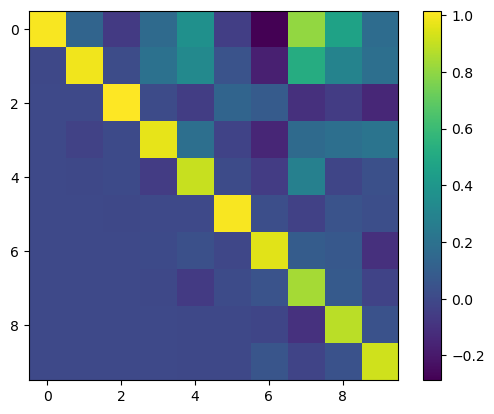

In [11]:
plt.imshow(K0)
plt.colorbar()

Spectrum of Koopman

In [12]:
E, V = np.linalg.eig(K0)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

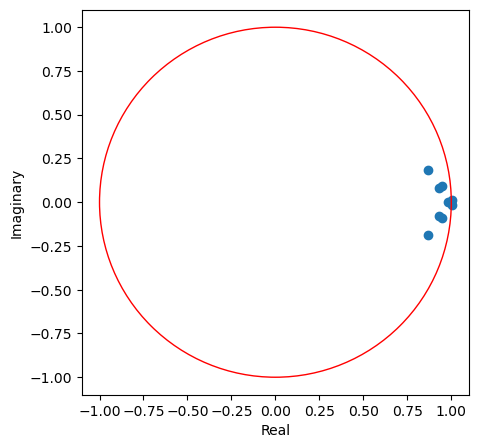

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

In [14]:
X.shape

torch.Size([995, 106, 160])

In [21]:
V[:,-2].real

array([ 0.45621374,  0.58981526, -0.09389551,  0.3428869 , -0.09921481,
       -0.02190752,  0.05782024, -0.17551844,  0.00614015, -0.01579799],
      dtype=float32)

In [23]:
V_proj = kann_.emb_engine.inverse_transform(V[:,-3:].real.T)
V_proj_rear = rearrange(torch.from_numpy(V_proj).float(), 'n (l f) -> n l f', l=5, f=32)

In [24]:
V_proj_rear.shape

torch.Size([3, 5, 32])

### per sample

In [7]:
states.targets.shape

(995,)

In [6]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(states.inputs, states.targets, test_size=0.2, random_state=42)

In [26]:
train_X.shape

(796, 106, 160)

In [9]:
from DMD.dmd import KANN
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Dim reduction
dim_red = 3
pca = PCA(n_components=dim_red)
train_X_red = pca.fit_transform(train_X.reshape(-1, train_X.shape[-1]))
val_X_red = pca.transform(val_X.reshape(-1, val_X.shape[-1]))

train_X_red = rearrange(train_X_red, '(b t) f -> b t f', b = train_X.shape[0], t=train_X.shape[1], f=dim_red)
val_X_red = rearrange(val_X_red, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=dim_red)

# Define the classifier
Kclassifier = LogisticRegression(max_iter=1000)

Ks = []

for x in train_X_red:
    kann_ = KANN(x[np.newaxis,:,:], k=0, emb=None)
    KL = kann_.compute_KOP()
    Ks.append(KL.flatten())

Ks = np.stack(Ks, axis=0)

# Train the classifier
Kclassifier.fit(Ks, train_y)

# Test the classifier
Ks_te = []

for x in val_X_red:
    kann_ = KANN(x[np.newaxis,:,:], k=0, emb=None)
    KL = kann_.compute_KOP()
    Ks_te.append(KL.flatten())

Ks_te = np.stack(Ks_te, axis=0)
y_pred = Kclassifier.predict(Ks_te)

In [10]:
accuracy = accuracy_score(val_y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5778894472361809


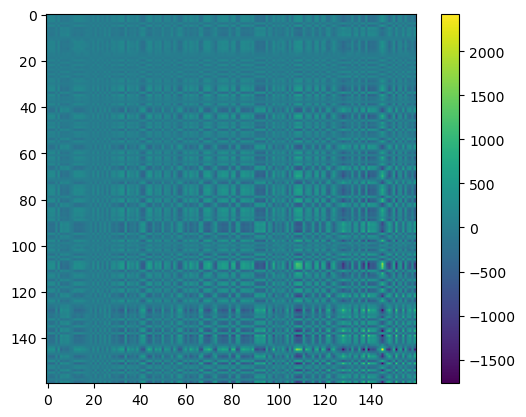

In [16]:
plt.imshow(pca.get_covariance(), cmap='viridis')
plt.colorbar()

In [16]:
train_X_red.shape

(796, 106, 3)

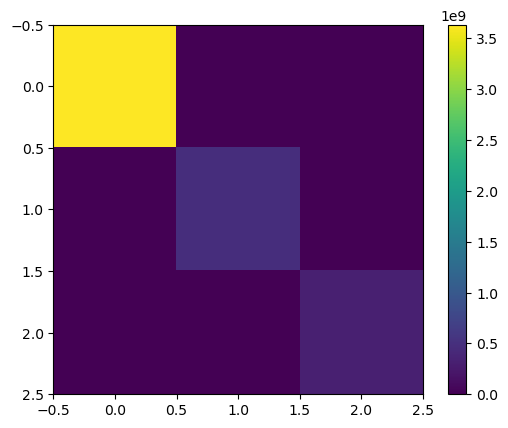

In [17]:
plt.imshow(train_X_red.reshape(-1,train_X_red.shape[-1]).T @ train_X_red.reshape(-1,train_X_red.shape[-1]), cmap='viridis')
plt.colorbar()

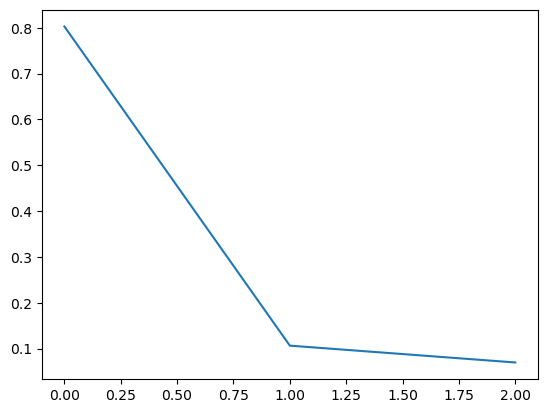

In [11]:
plt.plot(pca.explained_variance_ratio_)

In [18]:
import scipy

diag = (train_X_red.reshape(-1,train_X_red.shape[-1]).T @ train_X_red.reshape(-1,train_X_red.shape[-1])).diagonal()

scipy.special.softmax(diag)

array([1., 0., 0.], dtype=float32)

In [22]:
# Separate the data points based on the label
idx0 = train_y == 0
idx1 = train_y == 1
label_0 = train_X_red[idx0, -1, :2]
label_1 = train_X_red[idx1, -1, :2]

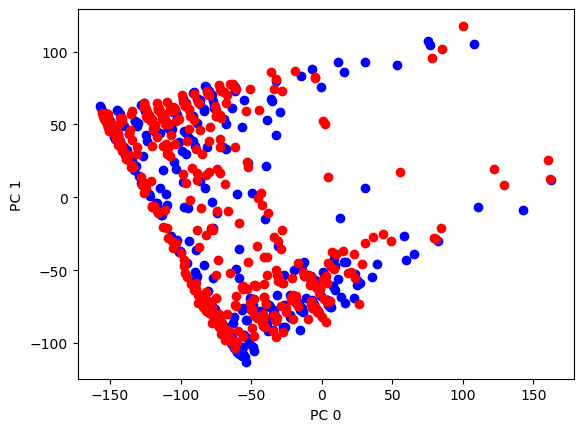

In [10]:
plt.scatter(label_0[:, 0], label_0[:, 1], c='blue', label='Label 0')
plt.scatter(label_1[:, 0], label_1[:, 1], c='red', label='Label 1')

# Add labels and title
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

PCA only of the last time step

In [8]:
from sklearn.decomposition import PCA

# Dim reduction
dim_red = 10
pca2 = PCA(n_components=dim_red)
train_X_red2 = pca2.fit_transform(train_X[:,-1,:])
val_X_red2 = pca2.transform(val_X[:,-1,:])

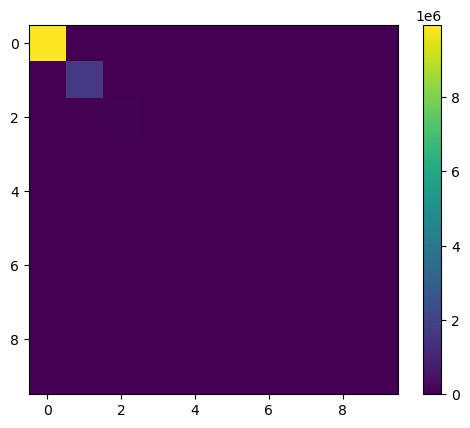

In [9]:
plt.imshow(train_X_red2.T @ train_X_red2, cmap='viridis')
plt.colorbar()

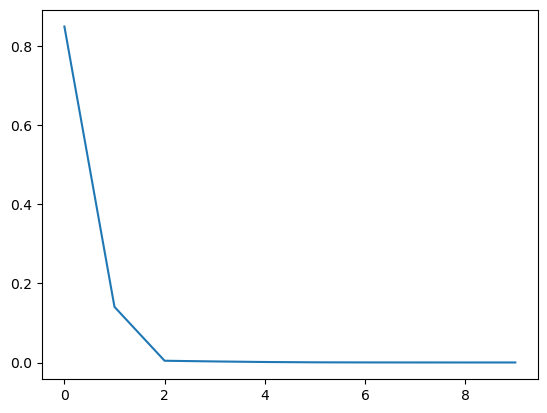

In [10]:
plt.plot(pca2.explained_variance_ratio_)

In [20]:
# Classify reduced states
# Create the classifier
classifier2 = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier2.fit(train_X_red2, train_y)

# Test the classifier
y_pred = classifier2.predict(val_X_red2)

accuracy = accuracy_score(val_y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8090452261306532


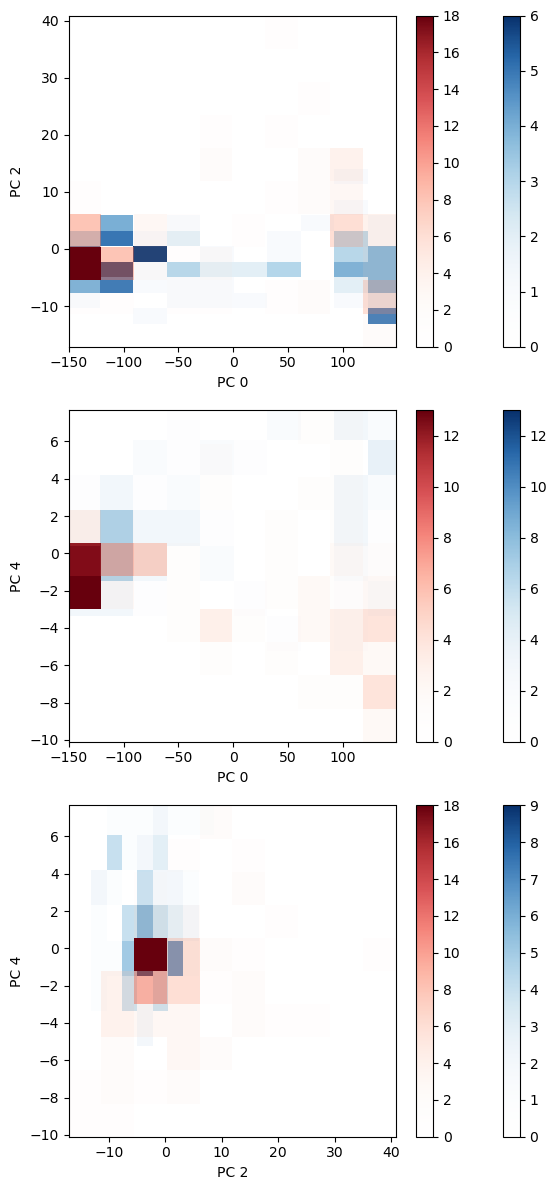

In [11]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

idx0 = val_y == 0
idx1 = val_y == 1
label_0 = val_X_red2[idx0]
label_1 = val_X_red2[idx1]

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# PC0 vs PC1
# Plot the first histogram in the first subplot
hist1 = axs[0].hist2d(label_0[:, 0], label_0[:, 2], bins=10, cmap=fading_blue, label='Label 0')
hist2 = axs[0].hist2d(label_1[:, 0], label_1[:, 2], bins=10, cmap=fading_red, label='Label 1')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 2')
plt.colorbar(hist1[3], ax=axs[0])
plt.colorbar(hist2[3], ax=axs[0])

# PC0 vs PC2
# Plot the first histogram in the first subplot
hist3 = axs[1].hist2d(label_0[:, 0], label_0[:, 4], bins=10, cmap=fading_blue, label='Label 0')
hist4 = axs[1].hist2d(label_1[:, 0], label_1[:, 4], bins=10, cmap=fading_red, label='Label 1')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 4')
plt.colorbar(hist3[3], ax=axs[1])
plt.colorbar(hist4[3], ax=axs[1])

# PC1 vs PC2
# Plot the first histogram in the first subplot
hist5 = axs[2].hist2d(label_0[:, 2], label_0[:, 4], bins=10, cmap=fading_blue, label='Label 0')
hist6 = axs[2].hist2d(label_1[:, 2], label_1[:, 4], bins=10, cmap=fading_red, label='Label 1')
axs[2].set_xlabel('PC 2')
axs[2].set_ylabel('PC 4')
plt.colorbar(hist5[3], ax=axs[2])
plt.colorbar(hist6[3], ax=axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for label_1 and label_0 data
df_label_0 = pd.DataFrame(label_0[:,[0,2,4]], columns=['PC0', 'PC2', 'PC4'])
df_label_1 = pd.DataFrame(label_1[:,[0,2,4]], columns=['PC0', 'PC2', 'PC4'])

# Add a column to indicate the label
df_label_0['label'] = 'Label 0'
df_label_1['label'] = 'Label 1'

# Concatenate the dataframes
df = pd.concat([df_label_0, df_label_1])

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='PC0', y='PC2', z='PC4', color='label')

# Show the plot
fig.show()

Plot showing the degrading of accuracy when reducing PCA component (retraining a regressor for each number of PCs)

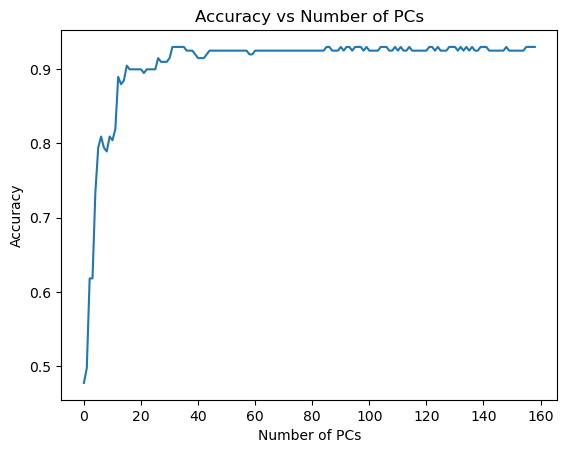

In [13]:
from sklearn.decomposition import PCA

accs = []
for dim_red in range(1, train_X.shape[-1]):
    pca3 = PCA(n_components=dim_red)
    train_X_red3 = pca3.fit_transform(train_X[:,-1,:])
    val_X_red3 = pca3.transform(val_X[:,-1,:])

    classifier3 = LogisticRegression(max_iter=5000, random_state=seed)
    classifier3.fit(train_X_red3, train_y)
    y_pred = classifier3.predict(val_X_red3)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

Check which PC contains more information

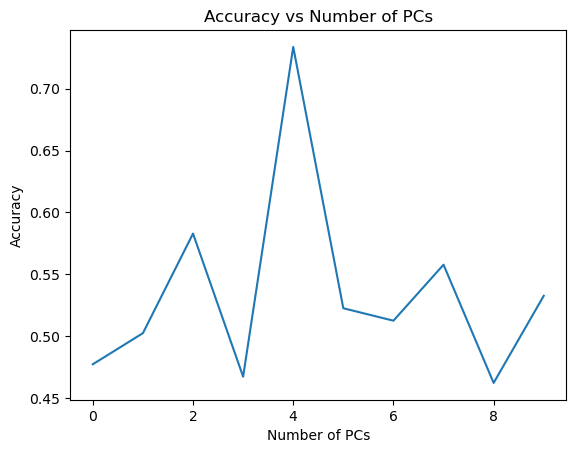

In [14]:
accs = []

pca4 = PCA(n_components=10)
train_X_red4 = pca4.fit_transform(train_X[:,-1,:])
val_X_red4 = pca4.transform(val_X[:,-1,:])

for i in range(0, train_X_red4.shape[-1]):
    x = train_X_red4[:,i]
    x = x[:, np.newaxis]
    classifier4 = LogisticRegression(max_iter=5000, random_state=seed)
    classifier4.fit(x, train_y)
    x = val_X_red4[:,i]
    x = x[:, np.newaxis]
    y_pred = classifier4.predict(x)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

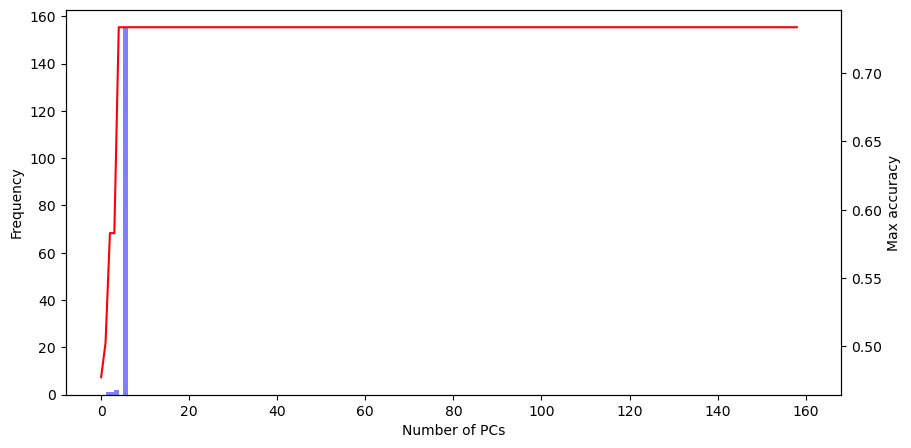

In [22]:
pc = []
max_accs = []

for dim_red in range(1, train_X.shape[-1]):
    pca4 = PCA(n_components=dim_red)
    train_X_red4 = pca4.fit_transform(train_X[:,-1,:])
    val_X_red4 = pca4.transform(val_X[:,-1,:])
    accs = []

    for i in range(0, train_X_red4.shape[-1]):
        x = train_X_red4[:,i]
        x = x[:, np.newaxis]
        classifier4 = LogisticRegression(max_iter=5000, random_state=seed)
        classifier4.fit(x, train_y)
        x = val_X_red4[:,i]
        x = x[:, np.newaxis]
        y_pred = classifier4.predict(x)
        accs.append(accuracy_score(val_y, y_pred))

    accs = np.array(accs)
    pc.append(np.argmax(accs) + 1)
    max_accs.append(np.max(accs))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.hist(pc, bins=train_X.shape[-1], range=(0, train_X.shape[-1]), alpha=0.5, color='blue')
ax1.set_ylabel('Frequency')

ax2 = ax1.twinx()
ax2.plot(max_accs, color='red')
ax2.set_ylabel('Max accuracy')
ax1.set_xlabel('Number of PCs')

plt.show()

In [23]:
max(set(pc), key=pc.count)

5

Keeping all time steps:
- PCA on last time step
- project all time steps onto the "most important" PC (whatever that is)

In [29]:
train_X.shape

(796, 106, 160)

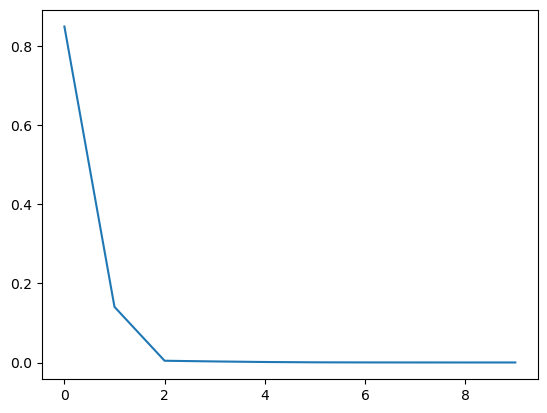

In [15]:
from sklearn.decomposition import PCA

# train_X5 = rearrange(train_X[:,40:,:], 'b t f -> (b t) f')

pca5 = PCA(n_components=10)
train_X_red5 = pca5.fit_transform(train_X[:,-1,:])

plt.plot(pca5.explained_variance_ratio_)

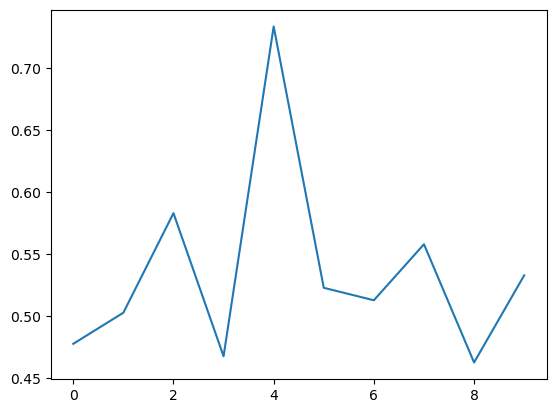

In [16]:
val_X_red5 = pca5.transform(val_X[:,-1,:])

accs = []

for i in range(0, val_X_red5.shape[-1]):
    x = train_X_red5[:,i]
    x = x[:, np.newaxis]
    classifier5 = LogisticRegression(max_iter=5000, random_state=seed)
    classifier5.fit(x, train_y)
    x = val_X_red5[:,i]
    x = x[:, np.newaxis]
    y_pred = classifier5.predict(x)
    accs.append(accuracy_score(val_y, y_pred))

plt.plot(accs)

In [13]:
pca5.components_.shape

(10, 160)

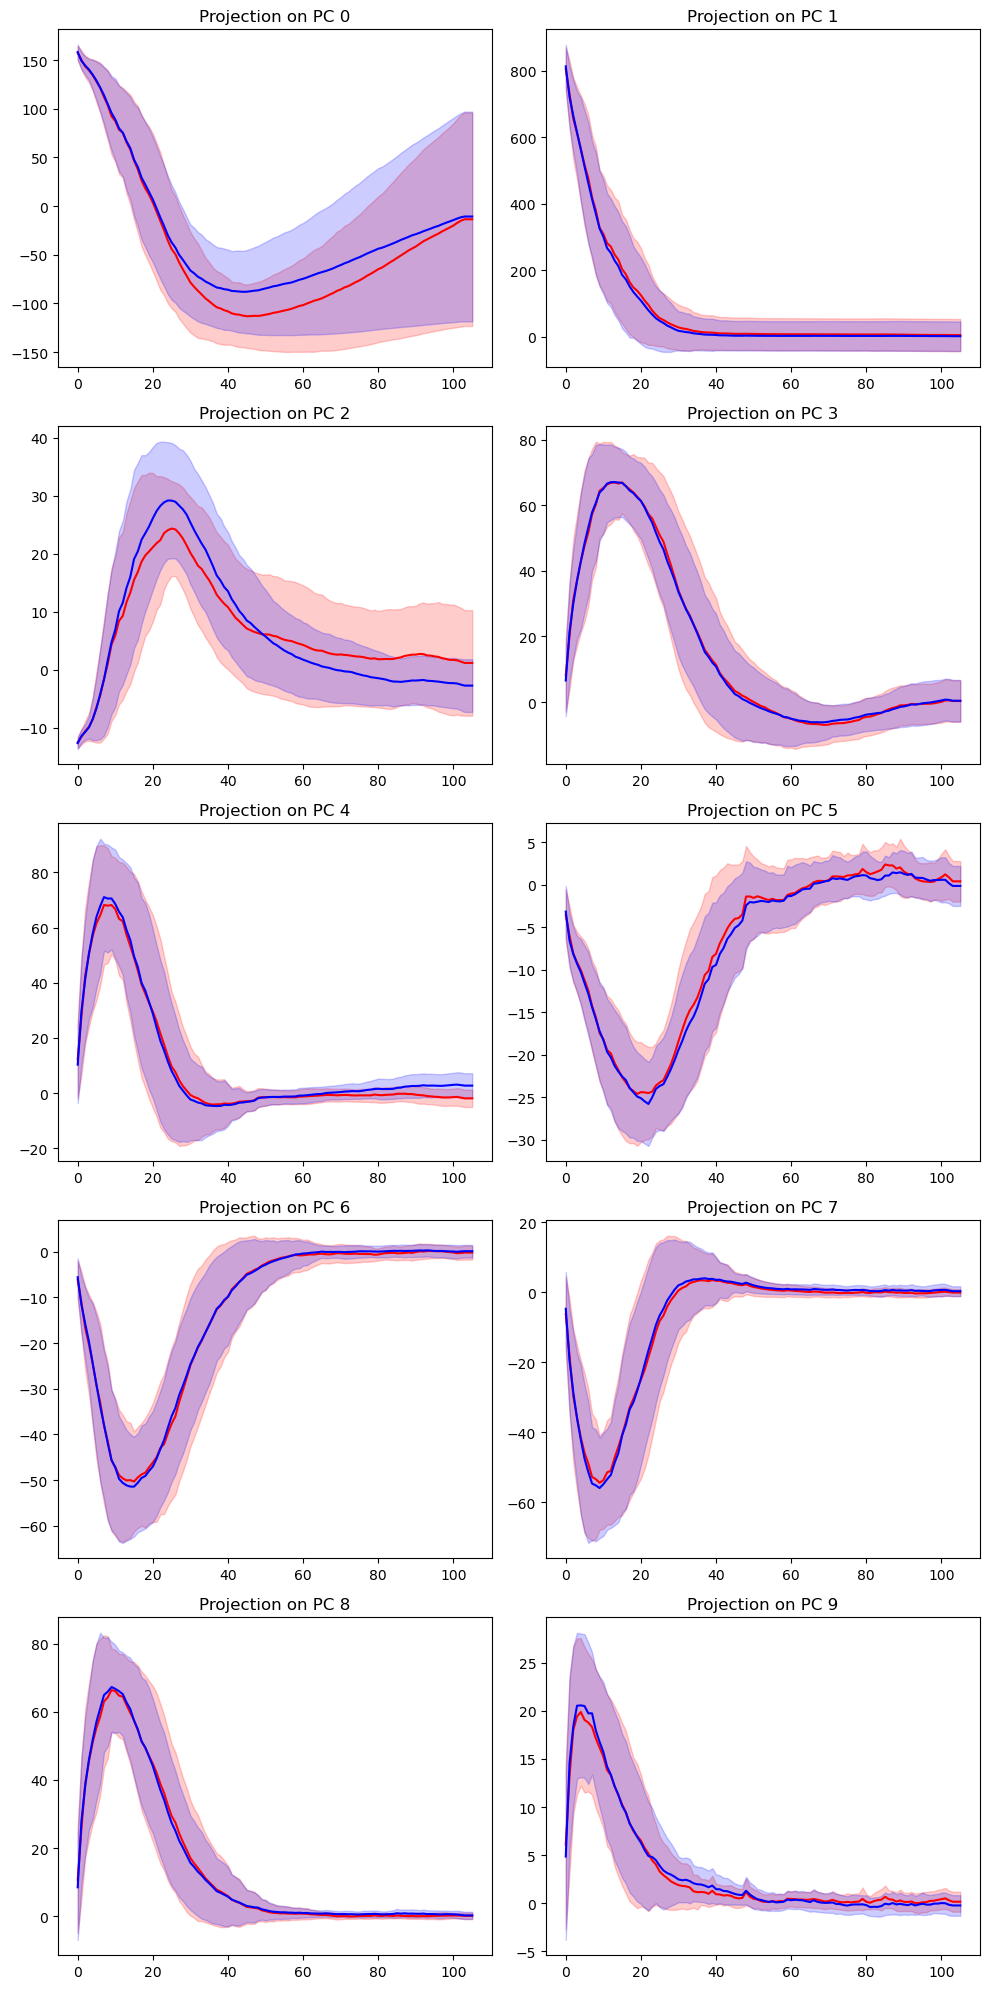

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

val_X_red5 = pca5.transform(rearrange(val_X, 'b t f -> (b t) f'))
val_X_red5 = rearrange(val_X_red5, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=10)

for i in range(10):
    val_proj5 = val_X_red5[:,:,i]

    m = val_proj5[val_y.astype(bool)].mean(axis=0)
    s = val_proj5[val_y.astype(bool)].std(axis=0)
    m_not = val_proj5[~val_y.astype(bool)].mean(axis=0)
    s_not = val_proj5[~val_y.astype(bool)].std(axis=0)

    axs[i//2, i%2].plot(m, c='r', label="class 1")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m-s, m+s, color='r', alpha=0.2)
    axs[i//2, i%2].plot(m_not, c='b', label="class 0")
    axs[i//2, i%2].fill_between(np.arange(m.shape[0]), m_not-s_not, m_not+s_not, color='b', alpha=0.2)
    axs[i//2, i%2].set_title(f'Projection on PC {i}')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [76]:
val_X.shape

(199, 106, 160)

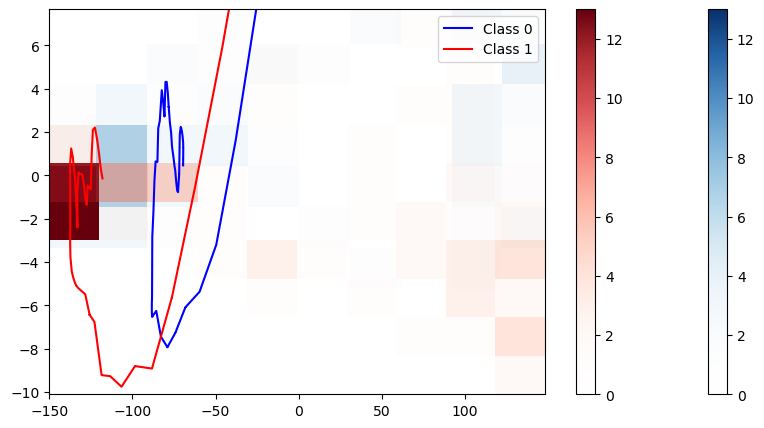

In [20]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

val_X_red6 = pca5.transform(val_X[:,-1,:])

val_proj60 = val_X_red6[~val_y.astype(bool)]
val_proj61 = val_X_red6[val_y.astype(bool)]

fig, ax = plt.subplots(figsize=(10, 5))

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

hist0 = ax.hist2d(val_proj60[:,0], val_proj60[:,4], bins=10, cmap=fading_blue)
hist1 = ax.hist2d(val_proj61[:,0], val_proj61[:,4], bins=10, cmap=fading_red)

plt.colorbar(hist0[3], ax=ax)
plt.colorbar(hist1[3], ax=ax)

# add one full trajectory for each class
val_X_rearr = rearrange(val_X, 'b t f -> (b t) f')
val_X_red7 = pca5.transform(val_X_rearr)
val_X_red7 = rearrange(val_X_red7, '(b t) f -> b t f', b = val_X.shape[0], t=val_X.shape[1], f=10)

traj0 = val_X_red7[1]
traj1 = val_X_red7[0]

ax.plot(traj0[:,0], traj0[:,4], c='blue', label='Class 0')
ax.plot(traj1[:,0], traj1[:,4], c='red', label='Class 1')

# Show the plot
plt.legend()
plt.show()

## ... at time step level

In [16]:
states.inputs.shape

(995, 106, 160)

## ... at node level

In [20]:
from sklearn.decomposition import PCA

torch.Size([200, 864, 170])

In [7]:
len(node_states)

995

In [9]:
node_states[1].shape

(106, 92, 160)

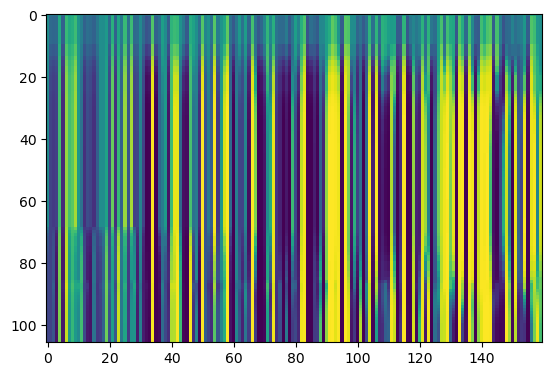

In [13]:
plt.imshow(node_states[1][:,4,:])

# Training DynGESN

In [2]:
import tsl

from dataset.utils import load_FB
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
edge_indexes, node_labels, graph_labels = load_FB(config['add_self_loops'])

In [29]:
data = []

for n in tqdm(range(len(node_labels))):
    data.append(
                tsl.data.data.Data(
                        input={'x': node_labels[n]},
                        target={'y': graph_labels[n]},
                        edge_index=edge_indexes[n]
                    ).to(device)
                )

train_data, test_data = train_test_split(data, test_size=0.2)

batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 995/995 [00:02<00:00, 335.87it/s]


In [35]:
y_l = []

for d in test_data:
    y_l.append(d.target['y'].item())

In [7]:
from models.DynGraphESN import DynGESNModel
import torch
import torch.nn as nn

# Define the linear model
class DGESN(nn.Module):
    def __init__(self, reservoir, input_size, output_size):
        super(DGESN, self).__init__()
        self.reservoir = reservoir
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        h = self.reservoir(x.input.x, x.edge_index, None).sum(dim=1)[-1,:,:]
        h = rearrange(h, 'l h -> (l h)')
        return self.linear(h)

model = DynGESNModel(input_size=1,
                    reservoir_size=config['reservoir_size'],
                    input_scaling=config['input_scaling'],
                    reservoir_layers=config['reservoir_layers'],
                    leaking_rate=config['leaking_rate'],
                    spectral_radius=config['spectral_radius'],
                    density=config['density'],
                    reservoir_activation=config['reservoir_activation'],
                    alpha_decay=config['alpha_decay'],
                    requires_grad=True,
                    b_leaking_rate=config['b_leaking_rate']).to(device)

classifier = DGESN(model, input_size=config['reservoir_size']*config['reservoir_layers'],
                              output_size=1).to(device)

In [49]:
from tqdm import trange
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=config['lr'])

classifier.train()

# Iterate over the training data
for epoch in range(50):
    running_loss = 0.0
    
    for data in tqdm(iter(train_dataloader)):
        labels = data.target.y
        optimizer.zero_grad()
        outputs = classifier(data)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_dataloader)}")

100%|██████████| 796/796 [04:10<00:00,  3.18it/s]


Epoch 1 - Loss: 52.70603077335434


100%|██████████| 796/796 [04:10<00:00,  3.18it/s]


Epoch 2 - Loss: 83.84004416924162


100%|██████████| 796/796 [04:10<00:00,  3.18it/s]


Epoch 3 - Loss: 49.91448544362244


100%|██████████| 796/796 [04:09<00:00,  3.18it/s]


Epoch 4 - Loss: 55.737126689739135


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 5 - Loss: 64.35693540216012


100%|██████████| 796/796 [04:09<00:00,  3.19it/s]


Epoch 6 - Loss: 50.93789785179927


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 7 - Loss: 52.9225494801444


100%|██████████| 796/796 [04:09<00:00,  3.19it/s]


Epoch 8 - Loss: 51.53479458568482


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 9 - Loss: 55.6069961581902


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 10 - Loss: 58.022338176845096


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 11 - Loss: 52.70742561247591


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 12 - Loss: 36.027284061675964


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 13 - Loss: 44.42496146684971


100%|██████████| 796/796 [04:09<00:00,  3.20it/s]


Epoch 14 - Loss: 49.372049692501434


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 15 - Loss: 58.31190979154753


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 16 - Loss: 42.99723631846424


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 17 - Loss: 52.91243984926772


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 18 - Loss: 50.47183268507685


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 19 - Loss: 68.00162937282289


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 20 - Loss: 45.10663124849997


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 21 - Loss: 47.69496832700927


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 22 - Loss: 52.54538669190667


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 23 - Loss: 39.73751256448493


100%|██████████| 796/796 [04:06<00:00,  3.22it/s]


Epoch 24 - Loss: 53.489458459889065


100%|██████████| 796/796 [04:06<00:00,  3.22it/s]


Epoch 25 - Loss: 49.792475367089395


100%|██████████| 796/796 [04:07<00:00,  3.21it/s]


Epoch 26 - Loss: 44.27362648950911


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 27 - Loss: 83.30705715597836


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 28 - Loss: 52.302342163071515


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 29 - Loss: 50.35112646344312


100%|██████████| 796/796 [04:07<00:00,  3.21it/s]


Epoch 30 - Loss: 37.15903615283665


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 31 - Loss: 57.22238981326361


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 32 - Loss: 52.461852388020546


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 33 - Loss: 51.66481017951042


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 34 - Loss: 42.2957095234991


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 35 - Loss: 60.39896774580004


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 36 - Loss: 51.03843801870575


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 37 - Loss: 52.674746331399966


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 38 - Loss: 53.73704882429137


100%|██████████| 796/796 [04:07<00:00,  3.22it/s]


Epoch 39 - Loss: 34.18929598863934


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 40 - Loss: 54.54873314449791


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 41 - Loss: 43.45307334056721


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 42 - Loss: 63.548268772213724


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 43 - Loss: 47.09881528725843


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 44 - Loss: 39.964744495034836


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 45 - Loss: 52.770184754342225


100%|██████████| 796/796 [04:08<00:00,  3.20it/s]


Epoch 46 - Loss: 54.129300182580074


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 47 - Loss: 40.01548644545303


100%|██████████| 796/796 [04:08<00:00,  3.21it/s]


Epoch 48 - Loss: 40.761226151055


100%|██████████| 796/796 [04:07<00:00,  3.21it/s]


Epoch 49 - Loss: 72.04903044013808


100%|██████████| 796/796 [04:07<00:00,  3.21it/s]

Epoch 50 - Loss: 62.36839605911237


In [50]:
# Specify the path to save the model
model_path = "models/saved/classifier_model.pt"

# Save the model
torch.save(classifier.state_dict(), model_path)

In [52]:
# Specify the path to the saved model
model_path = "models/saved/classifier_model.pt"

# Create an instance of the LinearRegression model
loaded_model = DGESN(model, input_size=config['reservoir_size']*config['reservoir_layers'],
                              output_size=1).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [53]:
loaded_model.eval()
y_h = []
y = []

for data in tqdm(iter(test_dataloader)):
    labels = data.target.y
    outputs = torch.heaviside(loaded_model(data), torch.tensor(0.))
    y_h.append(labels)
    y.append(outputs)

y_h = torch.cat(y_h)
y = torch.cat(y)

100%|██████████| 199/199 [00:32<00:00,  6.14it/s]


In [54]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_h.cpu().detach().numpy(), y.cpu().detach().numpy())
print(f"Accuracy: {accuracy}")

Accuracy: 0.6633165829145728


Koopman:

In [72]:
loaded_model.eval()
tr_states, tr_y = [], []
te_states, te_y = [], []

for data in tqdm(iter(train_dataloader)):
    tr_y.append(data.target.y)
    state = rearrange(loaded_model.reservoir(data.input.x, data.edge_index, None).sum(dim=1), 't l r -> t (l r)')
    tr_states.append(state)

for data in tqdm(iter(test_dataloader)):
    te_y.append(data.target.y)
    state = rearrange(loaded_model.reservoir(data.input.x, data.edge_index, None).sum(dim=1), 't l r -> t (l r)')
    te_states.append(state)

tr_states = torch.stack(tr_states).cpu().detach()
te_states = torch.stack(te_states).cpu().detach()
tr_y = torch.stack(tr_y).cpu().detach()
te_y = torch.stack(te_y).cpu().detach() 

100%|██████████| 199/199 [00:35<00:00,  5.63it/s]


In [98]:
from DMD.dmd import KANN

dim_red = 20
method = 'TruncatedSVD'

# compute local Koopman operator
kann_ = KANN(tr_states.cpu(), k=dim_red, emb=method)

K_trained = kann_.compute_KOP()

In [99]:
pred_states = []
s = kann_.emb_engine.transform(te_states[:,0,:])

for t in range(te_states.shape[1]):
    pred_states.append(torch.from_numpy(s))
    s = s @ K_trained

pred_states = torch.stack(pred_states, dim=1).squeeze()
pred_states = torch.from_numpy(kann_.recover_states(pred_states, dim_red))

In [100]:
pred_states.shape

torch.Size([199, 106, 80])

In [101]:
pred_y = loaded_model.linear(pred_states[:, -1, :].to(device)).cpu().detach()

accuracy = accuracy_score(te_y, torch.heaviside(pred_y, torch.tensor(0.)))

print(accuracy)

0.542713567839196


- M samples
- N nodi
- T time steps
- F features 

[M, sum(N), T[:-1], F] ---> [M, F]

- PCA F ---> [F, f]


[M, sum(N), T, F] ---> [MT, F]

- PCA F ---> f


[M, N, T, F] ---> [MNT, F]

- PCA F ---> f
- [MN, T, f] ---> K


**TODO**

- bidir
- media sul tempo o qualcosa di piu' avanzato dell'iultimo step
- tensorPCA per tenere separati M e N (e forse anche T se si riesce ad estendere tensorPCA a 4 dimensioni)